# 0. Install Dependencies

In [1]:
# !pip install tensorflow
# !pip install gym
# !pip install keras
# !pip install keras-rl2
# !pip install stable-baselines3

In [47]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Create environment follows Gym that SB3 supports

In [1]:
import random
import numpy as np
import gymnasium as gym
from gymnasium import spaces

class TaxiChargingEnv(gym.Env):
    def __init__(self):
        super(TaxiChargingEnv, self).__init__()
        # Actions we take: 0 kW, 7 kW, 14 kW, 22 kW
        self.action_space = spaces.Discrete(4)
        # State represents battery charge level (kWh)
        self.observation_space = spaces.Box(low=np.array([0]), high=np.array([100]), dtype=np.float32)
        # Initialize state
        self.state = 0.0
        # Battery capacity
        self.battery_capacity = 100.0  # kWh
        # Initial battery level
        self.battery_level = float(random.randint(20, 30))
        # Charging period (2 hours, every 15 minutes = 8 steps)
        self.steps_left = 8
        # Energy demand parameters
        self.mu = 30.0  # kWh
        self.sigma = 5.0  # kWh
        # Time coefficient for cost function
        self.alpha = 1

    def step(self, action):
        charging_rates = [0, 7, 14, 22]  # kW for each action
        power = charging_rates[action]

        # Calculate cost: charging cost (t,p) = 𝛼𝑡 * e^𝑝
        cost = self.alpha * np.exp(power/10)

        # Update battery level
        self.battery_level = min(self.battery_level + power / 4, self.battery_capacity) # each time 15 min, power * 15min = power * 1hour / 4

        # Reduce the steps left by 1
        self.steps_left -= 1

        # If steps are finished, calculate if the battery meets the demand
        if self.steps_left == 0:
            demand = np.random.normal(self.mu, self.sigma)
            if self.battery_level >= demand:
                reward = -cost  # Minimize cost, no penalty for meeting demand
            else:
                reward = -cost - 1000  # High penalty for not meeting demand
            terminated = True
        else:
            reward = -cost  # Incur cost for charging, continue episode
            terminated = False

        # Always set truncated to False in this environment
        truncated = False

        # State is the current battery level
        self.state = np.array([self.battery_level], dtype=np.float32)

        # Info dictionary
        info = {
            "battery_level": self.battery_level,
            "cost": cost
        }

        return self.state, reward, terminated, truncated, info

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        # Reset battery level
        self.battery_level = float(random.randint(20, 30))
        # Reset steps left
        self.steps_left = 8
        # Reset state
        self.state = np.array([self.battery_level], dtype=np.float32)
        return self.state, {}

    def render(self, mode='human', close=False):
        # For visualization, if needed
        pass

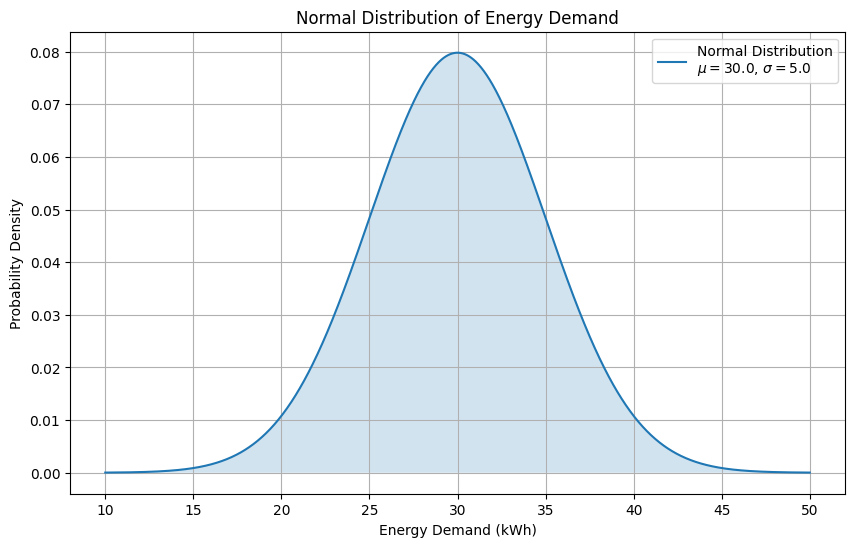

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters for the normal distribution
mu = 30.0  # Mean energy demand in kWh
sigma = 5.0  # Standard deviation in kWh

# Generate x values
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)

# Calculate the PDF of the normal distribution
pdf = norm.pdf(x, mu, sigma)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x, pdf, label=f'Normal Distribution\n$\mu={mu}$, $\sigma={sigma}$')
plt.fill_between(x, pdf, alpha=0.2)
plt.xlabel('Energy Demand (kWh)')
plt.ylabel('Probability Density')
plt.title('Normal Distribution of Energy Demand')
plt.legend()
plt.grid(True)
plt.show()


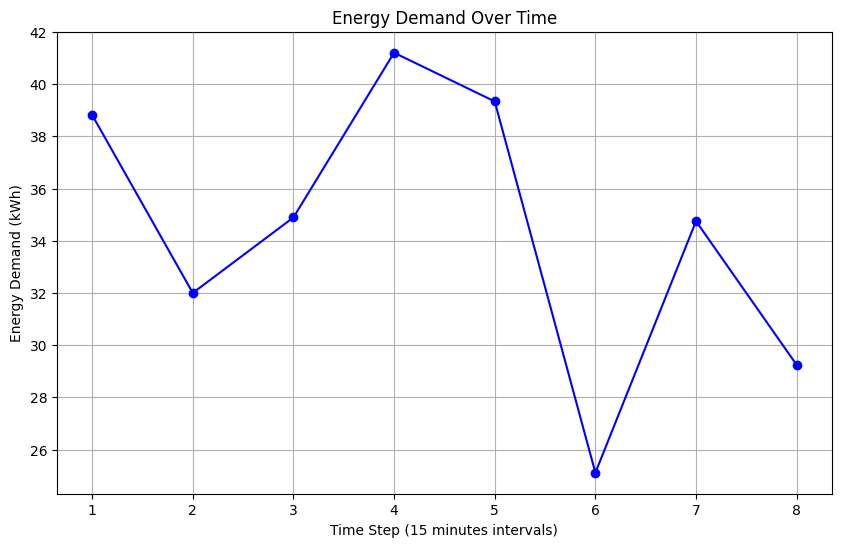

In [3]:
# Parameters
mu = 30.0  # Mean energy demand in kWh
sigma = 5.0  # Standard deviation in kWh
steps = 8  # Number of time steps

# Generate energy demand over time
np.random.seed(0)  # For reproducibility
energy_demand = np.random.normal(loc=mu, scale=sigma, size=steps)

# Time steps (assuming each step is 15 minutes, for simplicity we use integers)
time_steps = np.arange(1, steps + 1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(time_steps, energy_demand, marker='o', linestyle='-', color='b')
plt.xlabel('Time Step (15 minutes intervals)')
plt.ylabel('Energy Demand (kWh)')
plt.title('Energy Demand Over Time')
plt.grid(True)
plt.show()


In [4]:
# Create the environment
env = TaxiChargingEnv()

# 2. Validate and test the environment

In [5]:
#Check if the environment follow Gym interface that SB3 support
from stable_baselines3.common.env_checker import check_env
check_env(env)

In [6]:
obs, _ = env.reset()
env.render()

print(env.observation_space)
print(env.action_space)
print(env.action_space.sample())

# Random agent
n_steps = 8
for step in range(n_steps):
    action = env.action_space.sample()  # Random action
    print(f"Step {step + 1}")
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    print("obs=", obs, "reward=", reward, "done=", done, "info=", info)
    env.render()
    if done:
        print("Goal reached!", "reward=", reward)
        break

Box(0.0, 100.0, (1,), float32)
Discrete(4)
2
Step 1
obs= [22.75] reward= -2.0137527074704766 done= False info= {'battery_level': 22.75, 'cost': 2.0137527074704766}
Step 2
obs= [24.5] reward= -2.0137527074704766 done= False info= {'battery_level': 24.5, 'cost': 2.0137527074704766}
Step 3
obs= [30.] reward= -9.025013499434122 done= False info= {'battery_level': 30.0, 'cost': 9.025013499434122}
Step 4
obs= [35.5] reward= -9.025013499434122 done= False info= {'battery_level': 35.5, 'cost': 9.025013499434122}
Step 5
obs= [37.25] reward= -2.0137527074704766 done= False info= {'battery_level': 37.25, 'cost': 2.0137527074704766}
Step 6
obs= [42.75] reward= -9.025013499434122 done= False info= {'battery_level': 42.75, 'cost': 9.025013499434122}
Step 7
obs= [48.25] reward= -9.025013499434122 done= False info= {'battery_level': 48.25, 'cost': 9.025013499434122}
Step 8
obs= [48.25] reward= -1.0 done= True info= {'battery_level': 48.25, 'cost': 1.0}
Goal reached! reward= -1.0


# 3. Stable-Baselines

In [7]:
from stable_baselines3.common.env_util import make_vec_env
vec_env = make_vec_env(lambda: env, n_envs=1)

## 3.1 PPO

In [9]:
from stable_baselines3 import PPO

In [9]:
# Train the agent using PPO
model = PPO("MlpPolicy", vec_env, verbose=1) #Multi-Layer Perceptron Policy, which is a fully connected neural network. 
                                             #This policy will be used to approximate the Q-values in the PPO algorithm.
model.learn(total_timesteps=100000)

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8        |
|    ep_rew_mean     | -100     |
| time/              |          |
|    fps             | 5586     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 8           |
|    ep_rew_mean          | -48.1       |
| time/                   |             |
|    fps                  | 3400        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017805183 |
|    clip_fraction        | 0.303       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.37       |
|    explained_variance   | -2.67e-05   |
|    learning

In [10]:
# After training, save the model
model.save("ppo_taxi_charging")

In [10]:
model = PPO.load("ppo_taxi_charging")

## Test PPO model performance for 50 rounds

In [69]:
# Number of test episodes
num_episodes = 50

# List to store rewards for each episode
rewards = []

for episode in range(1, num_episodes + 1):
    state = vec_env.reset()
    done = False
    total_reward = 0

    while not done:
        action, _states = model.predict(state)
        state, reward, done, info = vec_env.step(action)
        total_reward += reward

    # Store the total reward for this episode
    rewards.append(total_reward)

    # Print the total reward for the current episode
    print(f"Episode {episode} - Total Reward: {total_reward}")

# Calculate the average reward
average_reward = np.mean(rewards)

print(f"\nAverage Reward over {num_episodes} episodes: {average_reward:.2f}")


Episode 1 - Total Reward: [-20.192915]
Episode 2 - Total Reward: [-26.317259]
Episode 3 - Total Reward: [-22.234364]
Episode 4 - Total Reward: [-22.234364]
Episode 5 - Total Reward: [-18.151468]
Episode 6 - Total Reward: [-15.09627]
Episode 7 - Total Reward: [-22.234365]
Episode 8 - Total Reward: [-22.234365]
Episode 9 - Total Reward: [-26.317257]
Episode 10 - Total Reward: [-19.179163]
Episode 11 - Total Reward: [-24.27581]
Episode 12 - Total Reward: [-31.287073]
Episode 13 - Total Reward: [-23.262058]
Episode 14 - Total Reward: [-20.192915]
Episode 15 - Total Reward: [-24.27581]
Episode 16 - Total Reward: [-22.234364]
Episode 17 - Total Reward: [-24.275812]
Episode 18 - Total Reward: [-24.27581]
Episode 19 - Total Reward: [-19.179163]
Episode 20 - Total Reward: [-24.275812]
Episode 21 - Total Reward: [-20.192915]
Episode 22 - Total Reward: [-20.192915]
Episode 23 - Total Reward: [-22.234364]
Episode 24 - Total Reward: [-20.192917]
Episode 25 - Total Reward: [-20.192917]
Episode 26 - 

In [70]:
# Extracting values from the numpy arrays
rewards_ppo = [reward[0] for reward in rewards]

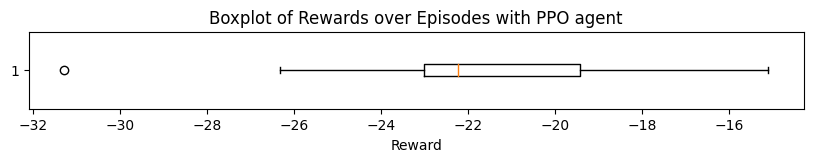

In [73]:
# Plotting the rewards as a boxplot
plt.figure(figsize=(10, 1))
plt.boxplot(rewards_ppo, vert=False)
plt.title('Boxplot of Rewards over Episodes with PPO agent')
plt.xlabel('Reward')
plt.savefig('boxplot_rewards_ppo.png', bbox_inches='tight')
plt.show()

# 4. Compare with random action

1.  code below show each rewards if we choose random action for 50 episode, as well as the average of 50 episodes
2.  if the test episode include the case that energy demand is higher than the energy we have, reward will be extremely low

In [64]:
def test_environment(env, num_episodes=50):
    rewards = []
    
    for episode in range(num_episodes):
        state, _ = env.reset()  # Reset the environment to start a new episode
        done = False
        total_reward = 0
        
        while not done:
            action = env.action_space.sample()  # Take a random action
            next_state, reward, done, truncated, info = env.step(action)
            total_reward += reward  # Accumulate the reward
            state = next_state  # Move to the next state
        
        rewards.append(total_reward)  # Store the total reward for this episode
        print(f"Episode {episode + 1} - Total Reward: {total_reward}")

    average_reward = np.mean(rewards)  # Calculate the average reward
    print(f"Average Reward over {num_episodes} episodes: {average_reward}")
    return rewards

# Test the environment with random actions for 50 episodes
rewards_random = test_environment(env, num_episodes=50)

Episode 1 - Total Reward: -26.20436610743862
Episode 2 - Total Reward: -14.096458089256103
Episode 3 - Total Reward: -37.28457957371742
Episode 4 - Total Reward: -20.080024329316032
Episode 5 - Total Reward: -21.234552574849175
Episode 6 - Total Reward: -1016.1379053486303
Episode 7 - Total Reward: -21.22061073041593
Episode 8 - Total Reward: -52.32085386511519
Episode 9 - Total Reward: -1016.1239635041971
Episode 10 - Total Reward: -32.187932347498545
Episode 11 - Total Reward: -35.24313231434322
Episode 12 - Total Reward: -37.157745880087994
Episode 13 - Total Reward: -41.22669855440314
Episode 14 - Total Reward: -28.118979673183397
Episode 15 - Total Reward: -33.20168505496902
Episode 16 - Total Reward: -18.165410763571256
Episode 17 - Total Reward: -18.165410763571256
Episode 18 - Total Reward: -27.2181188149091
Episode 19 - Total Reward: -23.275999834223374
Episode 20 - Total Reward: -1014.0964580892562
Episode 21 - Total Reward: -25.303505249164328
Episode 22 - Total Reward: -33.

In [65]:
# Extracting values from the numpy arrays
rewards_random

[-26.20436610743862,
 -14.096458089256103,
 -37.28457957371742,
 -20.080024329316032,
 -21.234552574849175,
 -1016.1379053486303,
 -21.22061073041593,
 -52.32085386511519,
 -1016.1239635041971,
 -32.187932347498545,
 -35.24313231434322,
 -37.157745880087994,
 -41.22669855440314,
 -28.118979673183397,
 -33.20168505496902,
 -18.165410763571256,
 -18.165410763571256,
 -27.2181188149091,
 -23.275999834223374,
 -1014.0964580892562,
 -25.303505249164328,
 -33.201685054969026,
 -25.176671555534902,
 -23.135224296160704,
 -28.118979673183397,
 -27.2181188149091,
 -37.157745880087994,
 -26.204366107438624,
 -40.21294584693267,
 -26.204366107438624,
 -41.24064039883639,
 -31.174179640028072,
 -14.096458089256105,
 -30.146485088124347,
 -33.08879320577284,
 -31.17417964002807,
 -35.1162986207138,
 -31.17417964002807,
 -28.118979673183397,
 -27.091285121279675,
 -37.157745880087994,
 -27.204176970475856,
 -31.17417964002807,
 -36.14399317261752,
 -1015.1241526411599,
 -23.149166140593948,
 -34.229

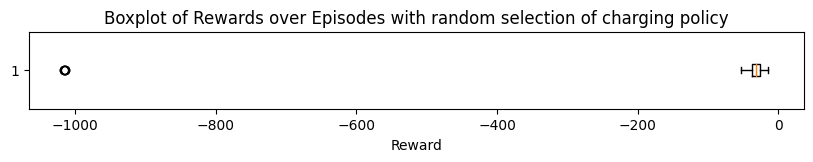

In [74]:
# Plotting the rewards as a boxplot
plt.figure(figsize=(10, 1))
plt.boxplot(rewards_random, vert=False)
plt.title('Boxplot of Rewards over Episodes with random selection of charging policy')
plt.xlabel('Reward')
plt.savefig('boxplot_rewards_random.png', bbox_inches='tight')
plt.show()